In [1]:
import os
import matplotlib.pyplot as plt
import gym
from gym_minigrid.wrappers import *
from gym_minigrid.envs import EmptyEnv
from gym_minigrid.minigrid import Grid
from gym.wrappers import *
import rl_representation as rl
from rl_representation.src.models import FTA
from rl_representation.src.envs.simulation import train_task_model
import torch
from torch import nn
import cv2
import numpy as np
import copy
import wandb
from tqdm import tqdm

# os.environ['WANDB_MODE'] = 'offline'
wandb.init()

%matplotlib inline

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ejmejm (use `wandb login --relogin` to force relogin)
C:\Users\ninja\.conda\envs\ml2\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [2]:
class GridEnv(EmptyEnv):
    def __init__(
            self,
            size=8,
            agent_start_pos=None,
            agent_start_dir=0,
            goal_start_pos=None):
        self.goal_start_pos = goal_start_pos
        super().__init__(size, agent_start_pos, agent_start_dir)

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Place a goal square in the bottom-right corner
        if self.goal_start_pos is None:
            self.put_obj(Goal(), self._rand_int(1, width-1), self._rand_int(1, width-1))
        else:
            self.put_obj(Goal(), self.goal_start_pos[0], self.goal_start_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "get to the green goal square"

In [3]:
class SimplifyObsWrapper(gym.ObservationWrapper):
  def __init__(self, env, grayscale=True, scale_factor=-1, rescale=True):
    super().__init__(env)
    self.grayscale = grayscale
    self.scale_factor = scale_factor
    self.rescale = rescale
    obs_shape = self.env.observation_space.shape
    if scale_factor > 0:
      new_shape = [int(obs_shape[0] * scale_factor), int(obs_shape[1] * scale_factor)]
    else:
      new_shape = [obs_shape[0], obs_shape[1]]
    if not grayscale:
      new_shape = [3] + new_shape

    self.observation_space = gym.spaces.Box(
        low=0, high=1, shape=new_shape, dtype=np.float32)

  def observation(self, observation):
    # Convert to grayscale
    if self.grayscale:
      observation = np.sum(observation * np.array([[[0.2989, 0.5870, 0.1140]]]), axis=2)
    else:
      observation = observation.transpose(2, 0, 1)

    # Downscale by a factor of 2
    if self.scale_factor > 0 and self.scale_factor != 1:
      observation = cv2.resize(observation, (0, 0), fx=self.scale_factor, fy=self.scale_factor)

    # Rescale obs to [0, 1]
    if self.rescale:
      observation = observation / 255.0
      
    return observation

class ColorShiftWrapper(gym.ObservationWrapper):
  def __init__(self, env, color=None, strength=0.3):
    super().__init__(env)
    if color is None:
      self.color = (np.random.rand(), np.random.rand(), np.random.rand())
    else:
      self.color = color
    self.color = np.array(self.color) * 255
    self.strength = strength
    self.filter_img = np.full(
      (self.env.observation_space.shape[0], self.env.observation_space.shape[1], 3),
      (self.color), dtype=np.float32)

  def observation(self, observation):
    return observation * (1 - self.strength) + self.filter_img * self.strength

def color_shift(obs, color, strength=0.3):
  color_arr = np.array(color).reshape(1, 1, 3)
  return obs * (1 - strength) + color_arr * strength

def reverse_color_shift(obs, color, strength=0.3):
  color_arr = np.array(color).reshape(1, 1, 3)
  return (obs - color_arr * strength) / (1 - strength)

class FlattenObservations(gym.ObservationWrapper):
  def __init__(self, env):
    super().__init__(env)
    obs_shape = self.env.observation_space.shape
    self.observation_space = gym.spaces.Box(
        low=0, high=1, shape=(np.prod(obs_shape),), dtype=np.float32)

  def observation(self, observation):
    return observation.reshape(-1)

class SimplifyActionsWrapper(gym.ActionWrapper):
  def __init__(self, env):
    super().__init__(env)
    self.action_space = gym.spaces.Discrete(3)

  def action(self, action):
    if action > 2:
      raise ValueError('Action must be between 0 and 2')
    return action

Shape: (4800,) => 4800


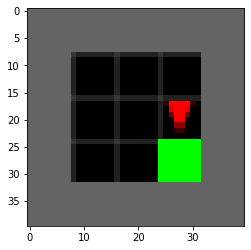

In [4]:
def make_env(color_shift=None, shift_strength=0.3):
    env = GridEnv(size=5) # gym.make('MiniGrid-Empty-Random-6x6-v0')
    env = RGBImgObsWrapper(env) # Get pixel observations
    env = ImgObsWrapper(env) # Get rid of the 'mission' field
    if color_shift:
        env = ColorShiftWrapper(env, color_shift, shift_strength)
    env = SimplifyObsWrapper(env, False) # Downscale and grayscale
    env = FlattenObservations(env)
    return env
    
env = make_env()
obs = env.reset() # This now produces an RGB tensor only

IMG_SHAPE = (3, 40, 40)
print('Shape:', obs.shape, '=>', np.prod(obs.shape))
plt.imshow(obs.reshape(IMG_SHAPE).transpose(1, 2, 0))

In [5]:
class ValueNetwork(nn.Module):
    def __init__(self, obs_dim, n_acts, encoder, hidden_size=128):
        super().__init__()
        self.encoder = encoder

        test_input = torch.zeros(1, *obs_dim)
        with torch.no_grad():
            self.encoder_output_size = encoder(test_input).view(-1).shape[0]

        fta = FTA(hidden_size)
        self.value_layers = nn.Sequential(
            self.encoder,
            nn.Flatten(),
            nn.Linear(self.encoder_output_size, hidden_size),
            fta,
            nn.Linear(hidden_size * fta.n_tiles, n_acts, bias=False))

        self._init_weights()

    def _init_weights(self):
        self.value_layers[-1].weight.data.fill_(0)
        # self.value_layers[-1].bias.data.fill_(0)

    def forward(self, x):
        return self.value_layers(x)

In [6]:
def chu_train(X, weights, n_epochs, batch_size, learning_rate=2e-2, precision=1e-30,
              anti_hebbian_learning_strength=0.4, lebesgue_norm=2.0, rank=2):
    sample_sz = X.shape[1]
    n_hidden = weights.shape[0]
    weights = copy.deepcopy(weights)
    for epoch in tqdm(range(n_epochs)):    
        eps = learning_rate * (1 - epoch / n_epochs)
        shuffled_epoch_data = X[torch.randperm(X.shape[0]),:]
        for i in range(X.shape[0] // batch_size):
            mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].cuda()            
            mini_batch = torch.transpose(mini_batch, 0, 1)            
            sign = torch.sign(weights)            
            W = sign * torch.abs(weights) ** (lebesgue_norm - 1)        
            tot_input=torch.mm(W, mini_batch)            
            
            y = torch.argsort(tot_input, dim=0)            
            yl = torch.zeros((n_hidden, batch_size), dtype = torch.float).cuda()
            yl[y[n_hidden-1,:], torch.arange(batch_size)] = 1.0
            yl[y[n_hidden-rank], torch.arange(batch_size)] =- anti_hebbian_learning_strength            
                    
            xx = torch.sum(yl * tot_input,1)            
            xx = xx.unsqueeze(1)                    
            xx = xx.repeat(1, sample_sz)                            
            ds = torch.mm(yl, torch.transpose(mini_batch, 0, 1)) - xx * weights            
            
            nc = torch.max(torch.abs(ds))            
            if nc < precision: nc = precision            
            weights += eps*(ds/nc)
    return weights

In [7]:
def draw_colored_weights(weights, n_cols, n_rows, sz=(3, 40, 40), text=None, size=(10, 10)):
    weights = weights.detach().cpu().numpy()
    weights = weights.reshape((-1, *sz)).transpose(0, 2, 3, 1)
    # Hidden node indices
    indexes = np.random.randint(0, weights.shape[0], n_cols*n_rows)
    weights = weights[indexes]
    fig=plt.figure(figsize=size)
    HM = np.zeros((sz[1]*n_rows, sz[2]*n_cols, sz[0]))
    for idx in range(n_cols * n_rows):
        x, y = idx % n_cols, idx // n_cols
        HM[y*sz[1]:(y+1)*sz[1],x*sz[2]:(x+1)*sz[2]] = weights[idx]
    plt.clf()
    low, high = HM.min(), HM.max()
    plt.imshow((HM - low) / (high - low))
    if text is not None: plt.title(text)
    plt.axis('off')
    return HM

def draw_weights(weights, n_cols, n_rows, sz=40, text=None, size=(10, 10)):
    weights = copy.deepcopy(weights).detach().cpu().numpy()
    weights = weights.reshape((-1, 3, sz, sz)).transpose(0, 2, 3, 1)
    weights = weights.mean(axis=3)
    indexes = np.random.randint(0, len(weights), n_cols*n_rows)
    weights = weights[indexes]
    fig=plt.figure(figsize=size)
    HM=np.zeros((sz*n_rows,sz*n_cols))
    for idx in range(n_cols * n_rows):
        x, y = idx % n_cols, idx // n_cols
        HM[y*sz:(y+1)*sz,x*sz:(x+1)*sz]=weights[idx]
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM, cmap='bwr', vmin=-nc, vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    if text is not None: plt.title(text)
    plt.axis('off')
    return weights

In [8]:
device = 'cuda'

hidden_size = 128
def create_agent():
    encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(np.prod(obs.shape), 256),
        nn.ReLU())
    model = ValueNetwork(
        list(env.observation_space.shape), env.action_space.n,
        encoder=encoder, hidden_size=hidden_size).to(device)
    agent = rl.agents.DDDQNAgent(env, model, log_freq=-1)

    return agent
    
agent = create_agent()

print([p.numel() for p in agent.model.parameters()])
print(sum([p.numel() for p in agent.model.parameters()]))
print(agent.model.value_layers)

[1228800, 256, 32768, 128, 17920]
1279872
Sequential(
  (0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4800, out_features=256, bias=True)
    (2): ReLU()
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): FTA()
  (4): Linear(in_features=2560, out_features=7, bias=False)
)


In [9]:
explore_steps = 10000
explore_agent = rl.agents.EzExplorerAgent(env, track_experience=True)
train_task_model(explore_agent, env, n_steps=explore_steps, print_freq=3000);

# Extract data
transitions = explore_agent.sample_buffer(explore_steps)
obs_dataset = transitions[0]

Step: 3000 | Episodes: 34 | Ep rewards: 0.1347
Step: 6000 | Episodes: 37 | Ep rewards: 0.2008
Step: 9000 | Episodes: 33 | Ep rewards: 0.1107


In [10]:
# Get weights
initial_weights = copy.deepcopy(list(agent.model.parameters())[0])
initial_weights.requires_grad = False

with torch.no_grad():
    new_weights = chu_train(obs_dataset, initial_weights, 50, 500)

100%|██████████| 50/50 [00:04<00:00, 10.52it/s]


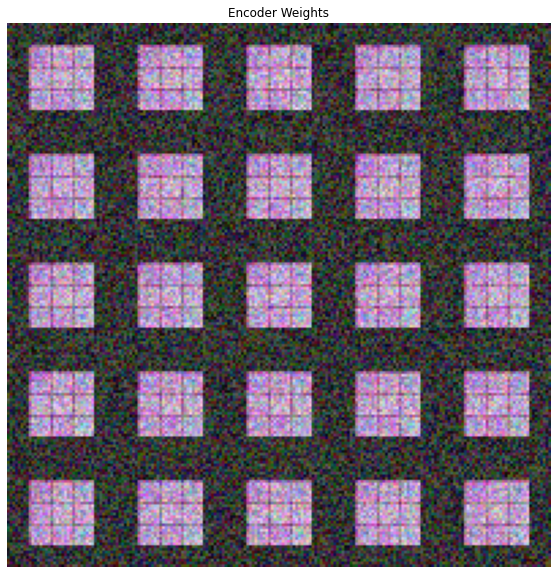

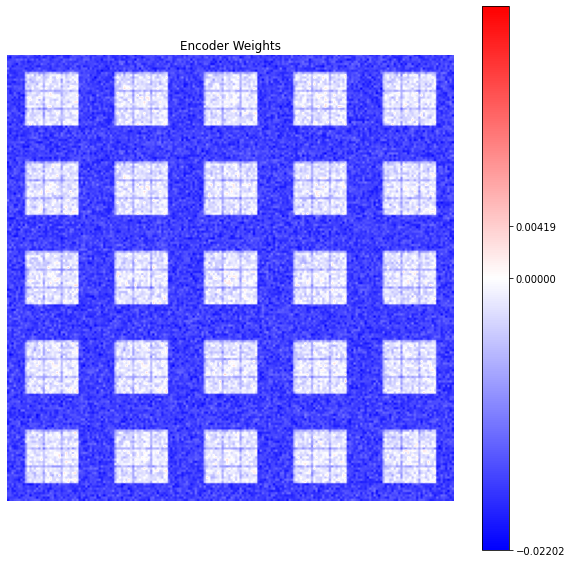

In [11]:
draw_colored_weights(new_weights, 5, 5, sz=(3, 40, 40), text='Encoder Weights');
draw_weights(new_weights, 5, 5, sz=40, text='Encoder Weights');

In [38]:
n_steps = 100000
print_freq = 1000

# Set encoder weight to learned weights and freeze them
encoder_weights = list(agent.model.parameters())[0]
with torch.no_grad():
    encoder_weights.data = new_weights.data
encoder_weights.requires_grad = False

train_task_model(agent, env, n_steps, print_freq=print_freq)

Step: 1000 | Episodes: 21 | Ep rewards: 0.5502
Step: 2000 | Episodes: 13 | Ep rewards: 0.3308
Step: 3000 | Episodes: 19 | Ep rewards: 0.4901
Step: 4000 | Episodes: 18 | Ep rewards: 0.4412
Step: 5000 | Episodes: 17 | Ep rewards: 0.4687
Step: 6000 | Episodes: 17 | Ep rewards: 0.4254
Step: 7000 | Episodes: 21 | Ep rewards: 0.5472
Step: 8000 | Episodes: 19 | Ep rewards: 0.5108
Step: 9000 | Episodes: 16 | Ep rewards: 0.3995
Step: 10000 | Episodes: 15 | Ep rewards: 0.3251


KeyboardInterrupt: 

In [74]:
def run_benchmark(agent, env, n_steps=int(1e5), n_runs=5):
    run_steps = []
    run_rewards = []
    for _ in tqdm(range(n_runs)):
        tmp_agent = copy.deepcopy(agent)
        steps, rewards = train_task_model(tmp_agent, env, n_steps, print_rewards=False)
        run_steps.append(steps)
        run_rewards.append(rewards)
    return run_steps, run_rewards

def moving_average(data, n=3) :
    ret = np.cumsum(data, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def bin_data(data, bin_size):
    binned_data = []
    for i, x in enumerate(data):
        if i % bin_size == 0:
            binned_data.append([])
        binned_data[-1].append(x)
    return binned_data

def generate_plot_data(y_data, bin_size=100, max_x=None):
    if len(y_data.shape) == 2:
        y_data = y_data.mean(axis=0)
    binned_y = bin_data(y_data, bin_size)
    print(binned_y)
    binned_y = np.array([np.average(bin_data) for bin_data in binned_y])
    print(binned_y)
    if max_x is None:
        max_x = len(binned_y)
        x_data = np.arange(len(binned_y)) * bin_size
    else:
        x_data = np.arange(len(binned_y)) / len(binned_y) * max_x
    print(binned_y)
    return x_data, binned_y

In [ ]:
per_run_steps = 20000
blank_agent = create_agent()

## Standard RL Test

In [ ]:
run_benchmark

## Frozen Weights Test

In [56]:
# Set encoder weight to learned weights and freeze them
encoder_weights = list(agent.model.parameters())[0]
with torch.no_grad():
    encoder_weights.data = new_weights.data
encoder_weights.requires_grad = False

results = run_benchmark(agent, env, n_steps=per_run_steps, n_runs=2)
x_data, y_data = generate_plot_data(results, bin_size=2, max_x=per_run_steps)
plt.title('tmp')
plt.plot(x_data, y_data)
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \
100%|██████████| 2/2 [14:19<00:00, 429.82s/it]
<ipython-input-54-b28ca5f5827b>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(run_rewards)


In [68]:

y_data = results.mean(axis=0)
binned_y = bin_data(y_data, 2)
binned_y = np.array([np.average(bin_data) for bin_data in binned_y])
binned_y

array([0.18025, 0.2455 , 0.10825, ..., 0.44825, 0.473  , 0.4775 ])

In [63]:
np.arange(len(y_data)) / len(y_data) * 1000

array([0])

In [73]:
y_data

array([[0.3605, 0.    , 0.    , ..., 0.4505, 0.4955, 0.4775]])

[[[0.721, 0, 0, 0.982, 0, 0.43299999999999994, 0, 0.883, 0.685, 0.8109999999999999, 0, 0, 0.757, 0.964, 0.469, 0.379, 0, 0, 0.604, 0, 0, 0.4959999999999999, 0, 0.946, 0, 0.55, 0.2709999999999999, 0, 0.847, 0, 0.883, 0.982, 0.82, 0, 0, 0.964, 0, 0.982, 0.37, 0, 0.991, 0.43299999999999994, 0.478, 0, 0.757, 0.991, 0, 0.9279999999999999, 0.10899999999999999, 0.5589999999999999, 0, 0, 0, 0, 0.874, 0, 0.3879999999999999, 0.856, 0.30699999999999994, 0.991, 0.982, 0.37, 0.5229999999999999, 0.55, 0.127, 0, 0, 0.982, 0.19899999999999995, 0.9369999999999999, 0.469, 0.712, 0, 0, 0, 0.991, 0.991, 0.5589999999999999, 0, 0.802, 0.991, 0, 0.32499999999999996, 0.892, 0.18999999999999995, 0.991, 0.955, 0.262, 0.6759999999999999, 0, 0.946, 0, 0.9279999999999999, 0.955, 0.973, 0.73, 0.91, 0, 0.685, 0, 0.586, 0.18999999999999995, 0.775, 0.991, 0.30699999999999994, 0.856, 0.973, 0.883, 0.973, 0.982, 0.802, 0.982, 0.991, 0.973, 0.892, 0.955, 0.964, 0.991, 0.964, 0.874, 0.946, 0.649, 0.856, 0.883, 0.685, 0.82

C:\Users\ninja\.conda\envs\ml2\lib\site-packages\numpy\lib\function_base.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


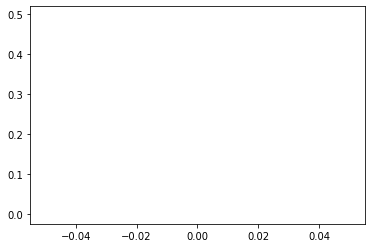

In [75]:

x_data, y_data = generate_plot_data(results, bin_size=2, max_x=per_run_steps)
plt.plot(x_data, y_data)
plt.show()

C:\Users\ninja\.conda\envs\ml2\lib\site-packages\numpy\lib\function_base.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


 ...]

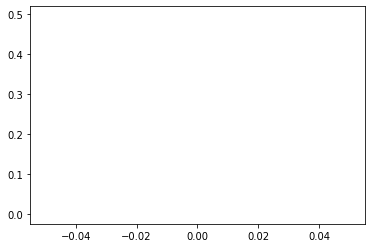

In [57]:
x_data, y_data = generate_plot_data(results, bin_size=2, max_x=per_run_steps)
plt.plot(x_data, y_data)

# Testing the agent

In [9]:
def test_agent(agent, env, n_episodes=10):
    rewards = []
    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        total_reward = 0.0
        global hist
        hist = []
        while not done:
            action = agent.sample_act(obs)
            obs, reward, done, _ = env.step(action)
            hist.append(obs)
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards)

In [10]:
base_reward = test_agent(agent, env, n_episodes=30)
print(f'Base agent reward: {base_reward:.2f}')

Base agent reward: 0.94


# Testing agent performance with color shifts

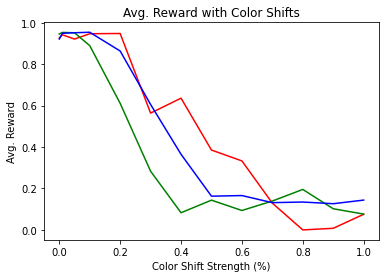

In [11]:
strengths = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
colors = {
    'r': (1, 0, 0),
    'g': (0, 1, 0),
    'b': (0, 0, 1)}

for color, rgb in colors.items():
    performance = []
    for strength in strengths:
        filter_env = make_env(color_shift=rgb, shift_strength=strength)
        filter_reward = test_agent(agent, filter_env, n_episodes=30)
        performance.append(filter_reward)

    # plot with red line color
    plt.plot(strengths, performance, color)

plt.title('Avg. Reward with Color Shifts')
plt.xlabel('Color Shift Strength (%)')
plt.ylabel('Avg. Reward');


## Remaining Tasks
- Create an activation function that zeros out certain nodes
- Get a mapping of the gradients for each nodes after many steps on the transfer task
- Make a function that makes a activation function mask for nodes within a certain percentile
- Try dropping those weights
- Try dropping nodes that meet a threshold number of outgoing weights dropped

In [12]:
def freeze_agent(agent):
    for param in agent.model.parameters():
        param.requires_grad = False
    for param in agent.target_model.parameters():
        param.requires_grad = False

def unfreeze_agent(agent):
    for param in agent.model.parameters():
        param.requires_grad = True
    for param in agent.target_model.parameters():
        param.requires_grad = True

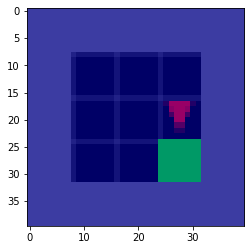

In [13]:
filter_env = make_env(color_shift=(0, 0, 1,), shift_strength=0.4)
plt.imshow(filter_env.reset().transpose(1, 2, 0))
transfer_agent = rl.agents.DDDQNAgent(filter_env, copy.deepcopy(agent.model), log_freq=-1, learning_start=int(1e9))

In [14]:
# Generate data
steps = 10000
train_task_model(transfer_agent, filter_env, steps, print_freq=print_freq*5)

Step: 5000 | Episodes: 87 | Ep rewards: 0.4403


In [87]:
# Get gradient errors on the transfer problem
transfer_agent.optimizer.zero_grad()
grad_steps = 50
grad_sums = [torch.zeros_like(p) for p in transfer_agent.model.parameters()]
for _ in range(grad_steps):
    transfer_agent.calculate_losses().mean().backward()
    for i, param in enumerate(transfer_agent.model.parameters()):
        grad_sums[i] += torch.abs(param.grad)
        # print(torch.sum(param.grad != 0) / param.numel())
        # break
    transfer_agent.optimizer.zero_grad()

e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \


In [68]:
# param = list(transfer_agent.model.parameters())[0]
# torch.sum(param == 0) / param.numel()
# torch.sum(grad_sums[0] != 0) / grad_sums[0].numel()

In [92]:
backup_ta = copy.deepcopy(transfer_agent)
reset_frac = 0.001
for i, (grads, param) in enumerate(zip(grad_sums, transfer_agent.model.parameters())):
    if i != len(grad_sums) - 2:
        continue
    reset_threshold = torch.quantile(grads, 1-reset_frac)
    reset_threshold = max(reset_threshold, 1e-5)
    mask = grads < reset_threshold
    print('Param #{}, {:.2f}% removed'.format(i, 100 - (mask.sum().item() / mask.numel() * 100)))
    with torch.no_grad():
        param *= mask.float()

Param #10, 0.11% removed


In [134]:
for p1, p2 in zip(backup_ta.model.parameters(), transfer_agent.model.parameters()):
    print('Differences:', torch.sum(p1 != p2).item())
print('Non-zero grad frac:', (grad_sums[-2].count_nonzero() / grad_sums[-2].numel()).item())

Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Differences: 0
Non-zero grad frac: 0.8504464626312256


In [15]:
removed_hidden_units = set([])
target_layer = list(transfer_agent.model.parameters())[-1]

for i in range(target_layer.shape[1]):
    print('\nPruning iteration #{}'.format(i+1))
    base_reward = test_agent(transfer_agent, filter_env, n_episodes=100)
    print(f'Base agent reward: {base_reward:.2f}')
    hidden_rewards = []
    for input_idx in range(target_layer.shape[1]):
        if input_idx in removed_hidden_units:
            hidden_rewards.append(-1)
        else:
            with torch.no_grad():
                old_vals = target_layer[:, input_idx]
                target_layer[:, input_idx] = 0
                reward = test_agent(transfer_agent, filter_env, n_episodes=50)
                hidden_rewards.append(reward)
                print('Hidden unit {}: {:.2f}'.format(input_idx, reward))
                target_layer[:, input_idx] = old_vals
    max_idx = np.argmax(hidden_rewards)
    if hidden_rewards[max_idx] > base_reward * 1.1:
        print('Removing hidden unit {}'.format(max_idx))
        with torch.no_grad():
            target_layer[:, max_idx] = 0
        removed_hidden_units.add(max_idx)
    else:
        break


Pruning iteration #1
Base agent reward: 0.48
Hidden unit 0: 0.42
Hidden unit 1: 0.27
Hidden unit 2: 0.21
Hidden unit 3: 0.40
Hidden unit 4: 0.21
Hidden unit 5: 0.35
Hidden unit 6: 0.47
Hidden unit 7: 0.38
Hidden unit 8: 0.40
Hidden unit 9: 0.34
Hidden unit 10: 0.35
Hidden unit 11: 0.47
Hidden unit 12: 0.32
Hidden unit 13: 0.50
Hidden unit 14: 0.34
Hidden unit 15: 0.23
Hidden unit 16: 0.39
Hidden unit 17: 0.40
Hidden unit 18: 0.38
Hidden unit 19: 0.45
Hidden unit 20: 0.28
Hidden unit 21: 0.24
Hidden unit 22: 0.34
Hidden unit 23: 0.30
Hidden unit 24: 0.30
Hidden unit 25: 0.44
Hidden unit 26: 0.21
Hidden unit 27: 0.38
Hidden unit 28: 0.48
Hidden unit 29: 0.42
Hidden unit 30: 0.32
Hidden unit 31: 0.14
Hidden unit 32: 0.26
Hidden unit 33: 0.44
Hidden unit 34: 0.23
Hidden unit 35: 0.19
Hidden unit 36: 0.25
Hidden unit 37: 0.19
Hidden unit 38: 0.27
Hidden unit 39: 0.10
Hidden unit 40: 0.10
Hidden unit 41: 0.08
Hidden unit 42: 0.13
Hidden unit 43: 0.14
Hidden unit 44: 0.07
Hidden unit 45: 0.1

In [109]:
base_reward = test_agent(transfer_agent, filter_env, n_episodes=10)
print(f'Transfer agent reward: {base_reward:.2f}')

Transfer agent reward: 0.49


In [101]:
transfer_agent = copy.deepcopy(backup_ta)

In [69]:
transfer_agent.model.value_layers[:-1]

Sequential(
  (0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9408, out_features=256, bias=True)
    (2): ReLU()
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
)

In [ ]:
transfer_agent.model.value_layers[:-1](torch.tensor([obs], device='cuda').float())

tensor([[0.1843, 0.0000, 0.0000, 0.1811, 0.0530, 0.0000, 0.0000, 0.2444, 0.0000,
         0.2402, 0.0000, 0.1215, 0.2800, 0.0000, 0.1117, 0.1126, 0.0000, 0.1164,
         0.1206, 0.0000, 0.0000, 0.0798, 0.0000, 0.0000, 0.2593, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0151, 0.0000, 0.1790, 0.0000, 0.1138, 0.0107, 0.0000,
         0.1679, 0.1016, 0.0000, 0.0000, 0.2751, 0.1968, 0.0000, 0.0000, 0.1790,
         0.0055, 0.1117, 0.1180, 0.1462, 0.0000, 0.0000, 0.0000, 0.0233, 0.2732,
         0.0160, 0.0236, 0.0000, 0.0000, 0.0228, 0.1675, 0.3149, 0.0000, 0.1594,
         0.0000, 0.1841, 0.0000, 0.1351, 0.1047, 0.1016, 0.1207, 0.0240, 0.1527,
         0.0178, 0.0000, 0.0000, 0.1431, 0.3437, 0.2592, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0529, 0.0000, 0.0051, 0.0000, 0.0000, 0.0000, 0.3146, 0.1377,
         0.0000, 0.1762, 0.0000, 0.3480, 0.0000, 0.0000, 0.0000, 0.2113, 0.0022,
         0.0000, 0.0000, 0.1245, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.1392, 0.0000, 0.2

In [63]:
transfer_agent.calculate_losses()

e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \


tensor([6.5002e-03, 6.5002e-03, 1.7247e-03, 1.0616e-03, 8.9955e-03, 6.2190e-03,
        4.4834e-03, 6.2189e-03, 2.8174e-02, 6.5002e-03, 6.2657e-03, 6.0987e-03,
        6.5002e-03, 1.1178e-02, 6.2190e-03, 6.5002e-03, 1.0072e-02, 7.3109e-03,
        6.2522e-03, 6.5002e-03, 4.3774e-02, 6.5002e-03, 6.5002e-03, 6.5002e-03,
        6.5002e-03, 3.3885e-01, 6.5002e-03, 6.5002e-03, 6.5002e-03, 3.4057e-03,
        6.5002e-03, 6.5002e-03, 1.3708e-03, 6.0987e-03, 1.0370e-02, 6.5002e-03,
        6.5002e-03, 8.0011e-04, 1.0692e-02, 6.5002e-03, 7.3109e-03, 2.1784e-04,
        3.0771e-02, 5.0356e-01, 6.5002e-03, 8.9077e-03, 6.5002e-03, 6.5002e-03,
        4.2381e-03, 4.6205e-02, 6.5002e-03, 3.4494e-03, 6.5002e-03, 6.5002e-03,
        6.6841e-02, 2.8750e-02, 6.5002e-03, 1.0072e-02, 4.4834e-03, 2.1395e-02,
        6.5002e-03, 6.2096e-03, 8.9955e-03, 6.2190e-03, 6.2190e-03, 5.0356e-01,
        3.4057e-03, 6.5002e-03, 6.2522e-03, 6.2190e-03, 6.2189e-03, 6.0987e-03,
        6.5002e-03, 8.9077e-03, 6.2190e-

In [55]:
a = list(transfer_agent.model.parameters())[2].grad
a.shape

torch.Size([128, 256])

In [74]:
print(list(transfer_agent.model.parameters())[-2].grad)
print(next(transfer_agent.model.parameters()).grad)
print(next(transfer_agent.model.parameters()).grad.sum())

tensor([[-2.7559e-03, -4.7504e-03, -1.2179e-04, -3.0968e-03, -2.8429e-04,
         -1.7875e-04, -1.6766e-03, -1.4572e-03, -7.1463e-04, -1.5418e-03,
          0.0000e+00, -5.3354e-03,  5.3874e-04, -2.5993e-04, -1.0417e-03,
         -8.3746e-04,  0.0000e+00, -6.4540e-03, -3.2519e-04,  0.0000e+00,
          0.0000e+00, -5.8134e-04,  0.0000e+00, -3.6056e-03, -7.7094e-04,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.6574e-03, -4.0612e-04,
          0.0000e+00, -9.3265e-03,  0.0000e+00, -2.7177e-03, -3.3994e-04,
         -1.7064e-04, -9.2044e-03, -9.3307e-04,  0.0000e+00,  0.0000e+00,
          5.4531e-04, -1.1952e-03,  0.0000e+00,  0.0000e+00, -1.4431e-03,
         -6.4529e-03, -9.0573e-04, -1.2076e-03, -1.0193e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -5.5482e-04,  5.2320e-04, -5.4833e-04,
          2.1238e-05, -7.7945e-05,  0.0000e+00, -4.6862e-04, -1.0566e-02,
          6.0719e-04,  0.0000e+00, -7.7247e-03, -1.1482e-03, -5.6607e-03,
         -1.9900e-04, -4.1855e-03, -7.

In [31]:
sum((next(transfer_agent.model.parameters()).grad != 0).view(-1))

KeyboardInterrupt: 

In [ ]:
transfer_agent.calculate_losses

In [32]:
transfer_agent.model.value_layers[0][1].weight.requires_grad

False

In [35]:
agent.model.value_layers[0][1].weight.requires_grad

True